# Data creation
## GDSC data preprocessing

Goal is to analyse and explore connections of multimodal data consisting of:
1. The GDSC2 data was gatered in raw format from: https://www.cancerrxgene.org/downloads/bulk_download, by command `wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/GDSC2_fitted_dose_response_25Feb20.xlsx -P /workspace/raw/GDSC2`, 
2. Compound and cell line annotation can be found on the same site: `wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/Cell_Lines_Details.xlsx -P /workspace/raw/GDSC2`, `wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/screened_compunds_rel_8.2.csv -P /workspace/raw/GDSC2`. Interastingly we can populate the data by analyzing a new modality of data of CCL specificaly: Mutation, Copy Number, Methylation and Expression. Which gives a new dimension to Drug Discovery finding correlations between the Human Cancer Cell features and the IC50 Label.
3. Missing drugs attributes were searched on online databases as https://www.chemspider.com/ and https://www.ebi.ac.uk/chembl/, but no new drugs features were found. Therefore we used only the described drugs within drugbank https://pubchem.ncbi.nlm.nih.gov/

Downloaded GDSC2 data was exported to csv and used for exploration. Using Omics data enriches attribute space greatly whether we use raw attributes or domain specific relevant features. Standard ML approaches or domain specific approaches will be utilized to reduce the number of features and ensure adequate prediction and rich representation covering main context of the problem of predicting the necesarry dose for in vitro half maximal inhibitory concentration (IC50) a measure of the drug potency in inhibiting a specific biological or biochemical function, indicating how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.

In [ ]:
# !wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/Cell_Lines_Details.xlsx -P /workspace/data/raw/GDSC2
# !wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/screened_compunds_rel_8.2.csv -P /workspace/data/raw/GDSC2
# !wget ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/GDSC2_fitted_dose_response_25Feb20.xlsx -P /workspace/data/raw/GDSC2


In [5]:
import pandas as pd
from pathlib import Path
import pubchempy as pcp
from rdkit import Chem
from pandas_profiling import ProfileReport
import json
from torch_geometric.data import Data, InMemoryDataset, Batch
import requests
import zipfile
import shutil
#

In [4]:
"""The data can be downloaded from the following link:
https://www.dropbox.com/s/cc8ovn0b1lsqm2m/raw.zip?dl=0
Unfortunately the data preprocessing and data creation 
takes 24 hour to complete if you do it yourself, you need to crawl
Pubchem to get compound info. 

After unpacking the data, make shure you match the folder sructure:
data\
    processed\
        ... # it will be created after the first run
    raw\
        CTRP\
        depmap22q2\
        GDSC2\
        ..."""
# downloads data folder if it doesn't exist

root = Path.cwd()
data_dir = (root / 'data')
raw_dir = (data_dir / 'raw')
if not raw_dir.exists():
    print("Downloading data (1.7 GB)")
    url = "https://www.dropbox.com/s/cc8ovn0b1lsqm2m/raw.zip?dl=0"

    with requests.get(url, stream=True) as r:
        with open(root / "raw.zip", 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    print("Data downloaded!")
    data_dir.mkdir()
    with zipfile.ZipFile(root / "raw.zip", "r") as zip_ref:
        zip_ref.extractall(data_dir)

In [ ]:
# with open('/workspace/data/raw/desc.json', 'w') as f:
#    json.dump(desc, f)
with open('/workspace/data/raw/desc.json', 'r', encoding='utf-8') as f:
    desc = json.load(f)

In [ ]:
def get_GDSC_pubchem_id(name, synonim_list=[], i=0):
    try:
        c= pcp.get_compounds(name, 'name')
        return c[0].cid
        
    except:
        for n in synonim_list:
            try:
                c= pcp.get_compounds(n, 'name')
                return c[0].cid
            except:
                pass
        print('{}, '.format(i))
        return 0

In [ ]:
# API to get the GDSC2 data from the raw data and pubchempy
def create_gdsc_mol_data():
    gdsc2_ccl_raw = pd.read_csv('/workspace/data/raw/GDSC2/GDSC2_fitted_dose_response_25Feb20.csv', sep=';')
    gdsc_compound_list = pd.read_csv('/workspace/data/raw/GDSC2/screened_compunds_rel_8.2.csv')
    pubchem_id = []
    for i in range(0,len(gdsc_compound_list)):
        if type(gdsc_compound_list.SYNONYMS[i]) == float:
            pubchem_id.append(get_GDSC_pubchem_id(gdsc_compound_list.DRUG_NAME[i],i=i))
        else:
            synonim_list=gdsc_compound_list.SYNONYMS[i].split(',')
            pubchem_id.append(get_GDSC_pubchem_id(gdsc_compound_list.DRUG_NAME[i], synonim_list=synonim_list, i=i))

    gdsc_compound_list_cid = gdsc_compound_list
    gdsc_compound_list_cid['pubchem_id'] = pd.Series(pubchem_id)
    
    #corrupt id check and move on get the smiles compound pubchem_id and other attributes for GDSC
    for i in range(0,int(len(gdsc_compound_list_cid)/100)):
        try:
            GDSC2_PubChem_all_temp = pcp.get_compounds(gdsc_compound_list_cid.pubchem_id.to_list()[i*100:(i+1)*100], as_dataframe=True)[
            desc['gdsc_all_columns']
        ]
            GDSC2_PubChem_all = pd.concat([GDSC2_PubChem_all, GDSC2_PubChem_all_temp])
        except:
            # download one by one and skip the corrupt line form puchempy 
            print("An exception occurred at {}".format(i))
            GDSC2_PubChem_all.to_csv('/workspace/data/raw/GDSC2/GDSC2_PubChem_all.csv')
            for k in range(0,100):
                try:
                    GDSC2_PubChem_all_temp = pcp.get_compounds(gdsc_compound_list_cid.pubchem_id.to_list()[i*100+k:(i)*100+k+1], as_dataframe=True)[
                        desc['gdsc_all_columns']]
                    GDSC2_PubChem_all = pd.concat([GDSC2_PubChem_all, GDSC2_PubChem_all_temp])
                except: 
                    print('{}, '.format(i*100+k))   
    GDSC2_PubChem_all.to_csv('/workspace/data/raw/GDSC2/GDSC2_PubChem_all.csv')
    GDSC2_PubChem_all= pd.read_csv('/workspace/data/raw/GDSC2/GDSC2_PubChem_all.csv')
    GDSC2_PubChem_all = GDSC2_PubChem_all.rename(columns={GDSC2_PubChem_all.columns[0]:'pubchem_id'})
    GDSC2_IC50_PUBCHEM = pd.merge(GDSC2_PubChem_all, gdsc_compound_list_cid, how="inner", on="pubchem_id").drop_duplicates()
    GDSC2_IC50_PUBCHEM = pd.merge( GDSC2_IC50_PUBCHEM, gdsc2_ccl_raw, how="inner", on="DRUG_ID").drop_duplicates()
    sample_info = pd.read_csv('/workspace/data/raw/depmap22q2/sample_info.csv')[['COSMICID', 'RRID']]
    GDSC2_IC50_PUBCHEM = GDSC2_IC50_PUBCHEM.merge(sample_info, how='inner', on='COSMICID')
    GDSC2_IC50_PUBCHEM.drop_duplicates(subset=['drug_name', 'RRID'], inplace=True)
    GDSC2_IC50_PUBCHEM.to_pickle('/workspace/data/raw/GDSC2/GDSC2_IC50_PUBCHEM.pkl')

# Helper functions to process the data
def string_to_fingerprint(x):
    return np.array([int(bit) for bit in x], dtype=np.int8)
def map_to_array(x):
    return ast.literal_eval(x)
def process_fingerprint_elements(x):
    x['cactvs_fingerprint'] = x['cactvs_fingerprint'].apply(string_to_fingerprint)
    x['elements'] = x['elements'].apply(map_to_array)
    x.to_pickle('/workspace/data/raw/GDSC2/GDSC2_IC50_PUBCHEM.pkl')
    return x

# GDSC2_IC50_PUBCHEM = pd.read_pickle('/workspace/data/raw/GDSC2/GDSC2_IC50_PUBCHEM.pkl')

In [ ]:
# GDSC2_IC50_PUBCHEM.to_pickle('/workspace/data/raw/GDSC2/GDSC2_IC50_PUBCHEM.pkl')

In [ ]:
GDSC2_IC50_PUBCHEM.columns

Index(['pubchem_id', 'atom_stereo_count', 'bond_stereo_count',
       'cactvs_fingerprint', 'canonical_smiles', 'charge', 'complexity',
       'covalent_unit_count', 'defined_atom_stereo_count',
       'defined_bond_stereo_count', 'effective_rotor_count_3d', 'elements',
       'exact_mass', 'fingerprint', 'h_bond_acceptor_count',
       'h_bond_donor_count', 'heavy_atom_count', 'inchi', 'inchikey', 'smiles',
       'isotope_atom_count', 'molecular_weight', 'monoisotopic_mass',
       'rotatable_bond_count', 'tpsa', 'undefined_atom_stereo_count',
       'undefined_bond_stereo_count', 'volume_3d', 'xlogp', 'DRUG_ID',
       'SCREENING_SITE', 'drug_name', 'SYNONYMS', 'TARGET', 'TARGET_PATHWAY',
       'DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'PUTATIVE_TARGET',
       'PATHWAY_NAME', 'COMPANY_ID', 'WEBRELEASE', 'MIN_CONC', 'MAX_CONC',
       'LN_IC50', 'AUC', 'RMSE', 'Z_SCORE', 'IC50'],
      dtype='object')

In [ ]:
sample_info = pd.read_csv('/workspace/data/raw/depmap22q2/sample_info.csv')[['COSMICID', 'RRID']]
GDSC2_IC50_PUBCHEM = GDSC2_IC50_PUBCHEM.merge(sample_info, how='inner', on='COSMICID')
GDSC2_IC50_PUBCHEM.drop_duplicates(subset=['drug_name', 'RRID'], inplace=True)

Cell line data can provide some specifics about the location of the mutation cells in the body. There are two attributes described by the Cell_Lines_Details.xlsx namely: `["GDSC Tissue descriptor 1",	"GDSC Tissue descriptor 2", "Cancer Type (matching TCGA label)"]`. Other interesting and potentially benefitial attributes for learning and prediction, could be the compounds to cell line realtion as [`"TARGET", "TARGET_PATHWAY"]`

Gather the pubchem_id for compounds used in gdsc dataset. We set zeros to 73 compounds that cannot be indentified in PubChem database. We check the synonims in the drug banks. We will ommit compounds that cannon't be identified. Create the compound list and find pubchem_id values to populate the list with smiles, fingerprints and other attributes. 

In [ ]:
# print(gdsc2_ccl_raw.head())
# print(gdsc2_ccl_raw.columns)
# print(gdsc2_ccl_raw.DRUG_NAME.unique())
# print(len(gdsc2_ccl_raw))

# print(gdsc_compound_list.head())
# print(gdsc_compound_list.columns)
# print(gdsc_compound_list.DRUG_NAME.unique())
# print(len(gdsc_compound_list))

## CTRPv2 data preprocessing

Data link:
https://ctd2-data.nci.nih.gov/Public/Broad/CTRPv2.0_2015_ctd2_ExpandedDataset/CTRPv2.0_2015_ctd2_ExpandedDataset.zip
Data location: `data/raw/CTRP/`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# json "dictionary" za pohranu imena atributa dimenzije značajki, ... 
# with open('/workspace/data/raw/desc.json', 'w') as f:
#    json.dump(desc, f)
with open('/workspace/data/raw/desc.json', 'r', encoding='utf-8') as f:
    desc = json.load(f)

" with open('/workspace/data/raw/desc.json', 'w') as f:\n    json.dump(desc, f) "

In [ ]:
def find_duplicates(exp_meta, col=''):
    duplicated = exp_meta[col].duplicated(keep=False)
    if duplicated.any():
        some_duplicates = exp_meta[duplicated].sort_values(by=exp_meta.columns.to_list())
        print(f"Dataframe has one or more duplicated rows, for example:\n{some_duplicates}")

In [ ]:
# Get pcp data for all compounds in CTRP
def get_cpd_pubchem_id(df):
    if os.path.isfile('/workspace/data/raw/CTRP/ctrp_pubchem.pkl'):
        return pd.read_pickle('/workspace/data/raw/CTRP/ctrp_pubchem.pkl')
    columns=desc['nci_all_columns_pc'].copy()
    columns.insert(0,'cid')
    pubchem_data = pd.DataFrame([], columns=columns) 
    for i in df.index:
        if pd.isna(df.loc[[i]]['cpd_name_1'].item()):
            try: 
                c =  get_single_pubchem(df.loc[[i]].cpd_smiles.item(),
                                        df.loc[[i]].cpd_name.item(),i) 
                # c = c.set_index(pd.Series([i]))
                pubchem_data = pd.concat([pubchem_data, c])
            except:
                print('error at {}'.format(i))
                
        else:
            try:
                c =  get_single_pubchem(df.loc[[i]].cpd_smiles_1.item(), 
                                        df.loc[[i]].cpd_name_1.item(),i)
                d =  get_single_pubchem(df.loc[[i]].cpd_smiles_2.item(), 
                                        df.loc[[i]].cpd_name_2.item(),i)
                d.set_axis([temp + '_2' for temp in columns], axis=1, inplace=True)
                c = pd.concat([c, d], axis=1)
                # c = c.set_index(pd.Series([i]))
                pubchem_data = pd.concat([pubchem_data, c])
            except:
                print('error at {}'.format(i))
    pubchem_data.to_pickle('/workspace/data/raw/CTRP/ctrp_pubchem.pkl')
    return pubchem_data

# Single compound       
def get_single_pubchem(cpd_smiles, cpd_name, i):
    try:
        c= pcp.get_compounds(cpd_smiles, 
                            'smiles', as_dataframe=True)[
                            desc['nci_all_columns_pc']]
        c = c.reset_index()
        c = c.set_index(pd.Series([i]))
        return  c
    except:
        try:
            c= pcp.get_compounds(cpd_name, 
                                'name', as_dataframe=True)[
                                desc['nci_all_columns_pc']]
            c = c.reset_index()
            c = c.set_index(pd.Series([i]))
            return  c
        except:
            return pd.DataFrame([])

In [ ]:
# Filter rows by values
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

# Pre pre processing of CTRP data regex cleaning and saving to pickle
def create_ctrp_pkl():
    if os.path.isfile('/workspace/data/raw/CTRP/CTRP_all_v2.pkl'):
        ctrp_new = pd.read_pickle('/workspace/data/raw/CTRP/CTRP_all_v2.pkl')
        return ctrp_new
    
    ctrp = pd.read_csv('/workspace/data/raw/CTRP/v20.data.curves_post_qc.txt', delimiter='\t')
    if os.path.isfile('/workspace/data/raw/CTRP/CTRP_PubChem_all.pkl'):
        cpd_meta = pd.read_pickle('/workspace/data/raw/CTRP/CTRP_PubChem_all.pkl')
        
    else:
        cpd_meta = pd.read_csv('/workspace/data/raw/CTRP/v20.meta.per_compound.txt', delimiter='\t')
        b = cpd_meta[cpd_meta['inclusion_rationale'] == 'combination']
        b[('cpd_name_1')] = b.loc[:,('cpd_name')].str.split(':').str[0].copy()
        b.loc[:,('cpd_name')].str.split(':').str[1].str.split(' \(').str[0]
        b['cpd_name_2'], b['ratio_1'] = b.loc[:,('cpd_name')].str.split(':').str[1].str.split(' \(').str[0], b.loc[:,('cpd_name')].str.split(':').str[1].str.split(' \(').str[1]
        b['ratio_2'] = b.loc[:,('cpd_name')].str.split(':').str[2].str.split(' ').str[0]
        b['cpd_smiles_1'], b['cpd_smiles_2'] = b.loc[:,('cpd_smiles')].str.split('.').str[0], b.loc[:,('cpd_smiles')].str.split('.').str[1]
        cpd_meta = pd.merge(cpd_meta,
                            b[ ['master_cpd_id', 'cpd_name_1', 'cpd_name_2', 
                                'ratio_1', 'ratio_2', 'cpd_smiles_1', 
                                'cpd_smiles_2']], how='left', on='master_cpd_id')
        
        pubchem_data = get_cpd_pubchem_id(cpd_meta)
        cpd_meta = pd.merge(cpd_meta[desc['cpd_meta_columns']], 
                            pubchem_data[desc['pubchem_ctrp_columns']], 
                            how='left', left_index=True, right_index=True)
        
        cpd_meta.to_pickle('/workspace/data/raw/CTRP/CTRP_PubChem_all.pkl')

    ctrp_new = pd.merge(ctrp, cpd_meta, how='left', on='master_cpd_id')
    experiment_meta = pd.read_csv('/workspace/data/raw/CTRP/v20.meta.per_experiment.txt', delimiter='\t')
    cell_line = pd.read_csv('/workspace/data/raw/CTRP/v20.meta.per_cell_line.txt', delimiter = '\t')
    exp_meta = pd.merge(experiment_meta, cell_line, how='left', on='master_ccl_id')
    exp_meta= exp_meta.drop_duplicates(subset=['experiment_id'])
    ctrp_new = pd.merge(ctrp_new, exp_meta, how='left', on='experiment_id')
    ctrp_new['LN_EC50'] = ctrp_new['apparent_ec50_umol'].map(lambda x: np.log(x))
    
    #Ovo nije pravi IC50 već EC50
    ctrp_new['LN_IC50'] = ctrp_new['LN_EC50']
    
    sample_info = pd.read_csv('/workspace/data/raw/depmap22q2/sample_info.csv')
    ctrp_new = pd.merge(ctrp_new, sample_info[desc['pubchem_ctrp_columns']], 
                        how='left', left_on='ccl_name', 
                        right_on='stripped_cell_line_name')
    
    ctrp_new['dataset_name'] = ['CTRP' for _ in range(0,len(ctrp_new))]
    ctrp_new.rename(columns={'cid':'pubchem_id', 'cid_2':'pubchem_id_2'}, inplace=True)
    pu = [desc['created_pubchem_ids'][smiles] for smiles in ctrp_new[pd.isna(
        ctrp_new.pubchem_id)]['cpd_smiles']]
    
    idx = ctrp_new[pd.isna(ctrp_new.pubchem_id)]['cpd_smiles'].index
    ctrp_new.loc[idx, 'pubchem_id'] = pu
    idx = ctrp_new[pd.isna(ctrp_new['isomeric_smiles'])].index
    ctrp_new.loc[idx, 'isomeric_smiles']=ctrp_new.loc[idx, 'cpd_smiles']
    ctrp_new = filter_rows_by_values(ctrp_new, 'RRID', 
                                     desc['cells_ctrp_missing_in_expression_depmap'])
    
    ctrp_new.to_pickle('/workspace/data/raw/CTRP/CTRP_all_v2.pkl')
    return ctrp_new

In [ ]:
ctrp_new = create_ctrp_pkl()

In [ ]:
ctrp_new = filter_rows_by_values(ctrp_new, 'RRID', desc['cells_ctrp_missing_in_expression_depmap'])

In [ ]:
ctrp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385993 entries, 0 to 395262
Data columns (total 65 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   experiment_id                   385993 non-null  int64  
 1   conc_pts_fit                    385993 non-null  int64  
 2   fit_num_param                   385993 non-null  int64  
 3   p1_conf_int_high                385993 non-null  float64
 4   p1_conf_int_low                 385993 non-null  float64
 5   p2_conf_int_high                385993 non-null  float64
 6   p2_conf_int_low                 385993 non-null  float64
 7   p4_conf_int_high                299190 non-null  float64
 8   p4_conf_int_low                 299190 non-null  float64
 9   p1_center                       385993 non-null  float64
 10  p2_slope                        385993 non-null  float64
 11  p3_total_decline                385993 non-null  float64
 12  p4_baseline     

In [ ]:
# Broj staničnih linija koje se ne nalaze u CCLE BP ali su u CTRP
# Potrebno ih je za komparaciju izbaciti ukupno 47 stanica
len(ctrp_new[pd.isna(ctrp_new['RRID'])]['ccl_name'].unique())
ctrp_labeled = ctrp_new.dropna(subset=['RRID'])

In [ ]:
desc['brain_tumors'] = ['Astrocytoma', 'Glioblastoma', 'Neuroblastoma', 'Medulloblastoma', 
'Gliosarcoma', 'Embryonal rhabdomyosarcoma',
'Biphasic synovial sarcoma', 'Undifferentiated pleomorphic sarcoma']

## NCI60 data preprocessing

NSC_PubChemSID.csv was found at https://wiki.nci.nih.gov/display/NCIDTPdata/Chemical+Data
IC50.csv Growth inghibition data was downloaded from https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-60+Growth+Inhibition+Data
The detailed description of Labels for NCI60 the compare methodology https://dtp.cancer.gov/databases_tools/docs/compare/compare_methodology.htm

In [ ]:
import sys
print(sys.path)

sys.path.append('/workspace/src')
print(sys.path)

['/', '/workspace', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/vscode/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/vscode/.ipython']
['/', '/workspace', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/vscode/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/vscode/.ipython', '/workspace/src']


In [ ]:
def print_number_of_unique_NCI_cell_names(NCI60_IC50_PUBCHEM, sample_info):
    k=0
    for i in NCI60_IC50_PUBCHEM.CELL_NAME.unique():
        l=re.sub('\W+','', i)
        print(l)
        if i in sample_info.cell_line_name.unique():
            print(True)
            k+=1
        elif l in sample_info.stripped_cell_line_name.unique():
            print(True)
            k+=1
        else: print(False)
    print(k)

In [ ]:
#Dump to JSON
#with open('/workspace/data/raw/desc.json', 'w') as f:
#    json.dump(desc, f)

In [ ]:
with open('/workspace/data/raw/desc.json', 'r', encoding='utf-8') as f:
    desc = json.load(f)

In [ ]:
# Get pubchem id for NCI60
def get_data_for_NCI(NCI60_PubChemSID):
    NCI60_properties = pd.DataFrame([])
    for i in range(0,int(len(NCI60_PubChemSID)/100)):
    #for i in range(297,300):
        try:
            NCI60_properties_temp = pcp.get_compounds(NCI60_PubChemSID.pubchem_id.to_list()[i*100:(i+1)*100], as_dataframe=True)[desc.nci_all_columns_pc]
            NCI60_properties = pd.concat([NCI60_properties, NCI60_properties_temp])
        except:
            print("An exception occurred at {}".format(i))
            NCI60_properties.to_csv('/workspace/data/raw/NCI60June2022/NSC_PubChem_all.csv')
            for k in range(0,100):
                try:
                    NCI60_properties_temp = pcp.get_compounds(NCI60_PubChemSID.pubchem_id.to_list()[i*100+k:(i)*100+k+1], as_dataframe=True)[desc.nci_all_columns_pc]
                    NCI60_properties = pd.concat([NCI60_properties, NCI60_properties_temp])
                except: 
                    print('{}, '.format(i*100+k))   
    NCI60_properties.to_csv('/workspace/data/raw/NCI60June2022/NSC_PubChem_all.csv')
    return NCI60_properties

In [ ]:
# Create NCI60 data pkl
def create_nci_data():
    NCI60_ccl_raw = pd.read_csv('/workspace/data/raw/NCI60June2022/IC50.csv')
    NCI60_PubChemSID = pd.read_csv('/workspace/data/raw/NCI60June2022/NSC_PubChemSID.csv', names=['NSC','pubchem_id'])
    # Operation lasts arround 3 hours
    NCI60_properties= get_data_for_NCI(NCI60_PubChemSID) 
    NCI60_IC50_PUBCHEM = pd.merge(NCI60_ccl_raw, NCI60_PubChemSID, how="inner", on="NSC").drop_duplicates()
    NCI60_properties['pubchem_id']=NCI60_properties.index
    NCI60_IC50_PUBCHEM = pd.merge(NCI60_IC50_PUBCHEM, NCI60_properties, how="inner", on="pubchem_id").drop_duplicates()
    NCI60_IC50_PUBCHEM['STRIPPED_CELL_NAME'] =NCI60_IC50_PUBCHEM.CELL_NAME.map(lambda x: re.sub('\W+','', x))
    sample_info = pd.read_csv('/workspace/data/raw/depmap22q2/sample_info.csv')
    NCI60_IC50_PUBCHEM_PUBLIC = pd.merge(NCI60_IC50_PUBCHEM, sample_info, 
        how="inner", left_on="STRIPPED_CELL_NAME", right_on='stripped_cell_line_name')
    c= ['RELEASE_DATE', 'EXPID', 'PREFIX','CELL_NUMBER',
    'cactvs_fingerprint','complexity', 'covalent_unit_count',
       'defined_atom_stereo_count', 'defined_bond_stereo_count',
       'elements','fingerprint','inchi', 'inchikey',
       'isotope_atom_count', 'molecular_weight', 'monoisotopic_mass', 
       'undefined_atom_stereo_count', 'undefined_bond_stereo_count',
       'volume_3d',  'STRIPPED_CELL_NAME','cell_line_name', 'alias',
       'sex', 'source', 'WTSI_Master_Cell_ID','depmap_public_comments',
       'default_growth_pattern', 'model_manipulation', 
       'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id']
    NCI60_IC50_PUBCHEM_PUBLIC.drop(columns=c, inplace=True)
    NCI60_IC50_PUBCHEM_PUBLIC.rename(columns={
                'RRID': 'cellosaurus_accession'}, inplace=True)
    # 
    NCI60_IC50_PUBCHEM_PUBLIC= NCI60_IC50_PUBCHEM_PUBLIC[NCI60_IC50_PUBCHEM_PUBLIC.CONCENTRATION_UNIT != 'V'] 
    NCI60_IC50_PUBCHEM_PUBLIC= NCI60_IC50_PUBCHEM_PUBLIC[NCI60_IC50_PUBCHEM_PUBLIC.CONCENTRATION_UNIT != 'u']
    
    # Values in GDSC DB are written as LN(IC50 * [1e-6 M]) = "LN_IC50"
    # Values in NCI60 are written as LOG10(IC50) = "AVERAGE"
    # Converting the values to "LN_IC50" = LN(IC50*1e6)
    NCI60_IC50_PUBCHEM_PUBLIC["IC50"] = NCI60_IC50_PUBCHEM_PUBLIC["AVERAGE"].map(lambda x: 10**x)
    NCI60_IC50_PUBCHEM_PUBLIC["LN_IC50"] = NCI60_IC50_PUBCHEM_PUBLIC["IC50"].map(lambda x: np.log(x*1e+6))
    NCI60_IC50_PUBCHEM_PUBLIC = NCI60_IC50_PUBCHEM_PUBLIC[
        ~NCI60_IC50_PUBCHEM_PUBLIC.pubchem_id.isin(desc['bad_mols_nci60_drop'])].info()
    
    NCI60_IC50_PUBCHEM.to_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM.pkl')
    NCI60_IC50_PUBCHEM_PUBLIC.to_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')

In [ ]:
# Create and merge GDSC, NCI60 and CCLE data necessary for training
def create_labeled_data():
    sample_info = pd.read_csv('/workspace/data/raw/depmap22q2/sample_info.csv')
    gdsc = pd.read_pickle('/workspace/data/raw/GDSC2/GDSC2_IC50_PUBCHEM.pkl')
    nci_public = pd.read_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')
    gdsc = gdsc.merge(sample_info[['Sanger_Model_ID', 'RRID', 'stripped_cell_line_name']], how='inner', 
        left_on='SANGER_MODEL_ID', right_on='Sanger_Model_ID')
    
    gdsc['dataset_name'] = ['GDSC' for i in range(len(gdsc))]
    labeled_data = gdsc[['pubchem_id', 'LN_IC50', 
        'drug_name', 'dataset_name', 'RRID', 'smiles',
        'stripped_cell_line_name', 'SANGER_MODEL_ID']]
    
    nci_public.rename(columns={
                    'isomeric_smiles': 'smiles',
                    'Sanger_Model_ID':'SANGER_MODEL_ID'
                    }, inplace=True)
    
    nci_public['dataset_name'] = ['NCI60' for i in range(len(nci_public))]
    nci_public['drug_name'] = ['' for i in range(len(nci_public))]
    nci_labeled_data= nci_public[['pubchem_id', 'LN_IC50', 
        'drug_name', 'dataset_name', 'RRID', 'smiles',
        'stripped_cell_line_name', 'SANGER_MODEL_ID']]
    nci_labeled_data= nci_labeled_data[~nci_labeled_data.pubchem_id.isin(desc['bad_mols_nci60_drop'])]

    
    ld  = pd.concat([labeled_data, nci_labeled_data]) 
    # CTRP cell lines have 47 Cell lines not in Depmap portal
    ctrp = pd.read_pickle('/workspace/data/raw/CTRP/CTRP_all_v2.pkl')
    ctrp = ctrp[ctrp['apparent_ec50_umol']!= 0]
    ctrp_labeled = ctrp[['pubchem_id', 'LN_IC50','cpd_name','dataset_name','RRID', 
     'isomeric_smiles','ccl_name', 'cpd_smiles']].rename(columns={ 
            'cpd_name':'drug_name', 'cpd_smiles':'smiles_old',
            'isomeric_smiles':'smiles','ccl_name':'stripped_cell_line_name'})
     
    ld =pd.concat([ld, ctrp_labeled])
    ld.to_pickle('/workspace/data/processed/labeled_data.pkl')
    return ld
# create_labeled_data()

In [ ]:
# Create the data for Drug Response Prediction
def create_labeled_data_drp():
    nci_public = pd.read_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')
    selection = pd.read_csv('/workspace/data/raw/NCI60June2022/nci60_selection_marker_genes.csv')    
    nci_public.rename(columns={
                    'isomeric_smiles': 'smiles',
                    'Sanger_Model_ID':'SANGER_MODEL_ID'
                    }, inplace=True)
    
    nci_public['dataset_name'] = ['NCI60_DRP' for i in range(len(nci_public))]
    nci_public['drug_name'] = ['' for i in range(len(nci_public))]
    nci_labeled_data= nci_public[['pubchem_id', 'LN_IC50', 
        'drug_name', 'dataset_name', 'RRID', 'smiles',
        'stripped_cell_line_name', 'SANGER_MODEL_ID']]
    nci_labeled_data = nci_labeled_data.loc[nci_labeled_data['RRID'].isin(selection.cellosaurus_id.unique())]
    nci_labeled_data= nci_labeled_data[~nci_labeled_data.pubchem_id.isin(desc['bad_mols_nci60_drop'])]
    nci_labeled_data.to_pickle('/workspace/data/processed/labeled_data_drp.pkl')
    return nci_labeled_data

In [ ]:
# NCI60_IC50_PUBCHEM_PUBLIC.to_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')

In [ ]:
drp = create_labeled_data_drp()

In [ ]:
drp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535637 entries, 412774 to 3225858
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pubchem_id               535637 non-null  int64  
 1   LN_IC50                  535637 non-null  float64
 2   drug_name                535637 non-null  object 
 3   dataset_name             535637 non-null  object 
 4   RRID                     535637 non-null  object 
 5   smiles                   535637 non-null  object 
 6   stripped_cell_line_name  535637 non-null  object 
 7   SANGER_MODEL_ID          535637 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 36.8+ MB


In [ ]:
desc['test_5000']=drp.pubchem_id.unique()[:5000].tolist()

In [ ]:
nci_public = pd.read_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')

In [ ]:
# Not available from online source 
# TODO: Add the data to the repo
selection = pd.read_csv('/workspace/data/raw/NCI60June2022/nci60_selection_marker_genes.csv')

In [ ]:
# Read the data
labeled_data = pd.read_pickle('/workspace/data/processed/labeled_data.csv')

In [ ]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3834399 entries, 0 to 395262
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   pubchem_id               object 
 1   LN_IC50                  float64
 2   drug_name                object 
 3   dataset_name             object 
 4   RRID                     object 
 5   smiles                   object 
 6   stripped_cell_line_name  object 
 7   SANGER_MODEL_ID          object 
dtypes: float64(1), object(7)
memory usage: 263.3+ MB


<AxesSubplot:ylabel='Frequency'>

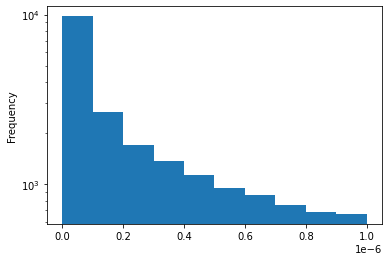

In [ ]:
gdsc["IC50"][gdsc["IC50"]<=1e-6].plot(kind='hist',logy=True)

<AxesSubplot:ylabel='Frequency'>

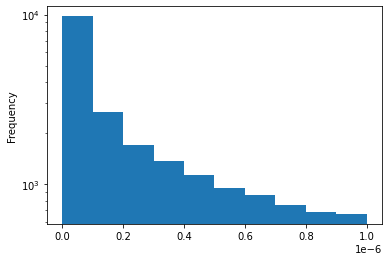

In [ ]:
gdsc["IC50"][gdsc["IC50"]<=1e-6].plot(kind='hist',logy=True)

In [ ]:
nci_public["IC50"] = nci_public["AVERAGE"].map(lambda x: 10**x)
nci_public["LN_IC50"] = nci_public["IC50"].map(lambda x: np.log(x*1e+6))

<AxesSubplot:ylabel='Frequency'>

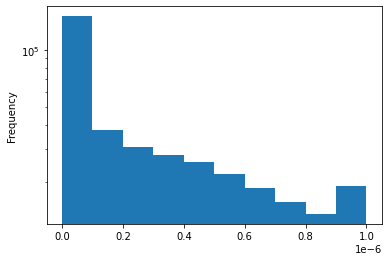

In [ ]:
nci_public["IC50"][nci_public["IC50"]<=1e-6].plot(kind='hist', logy=True)

<AxesSubplot:ylabel='Frequency'>

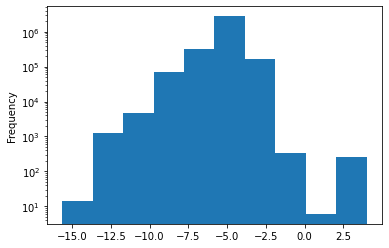

In [ ]:
nci_public.AVERAGE.plot(kind='hist', logy=True)

<AxesSubplot:ylabel='Frequency'>

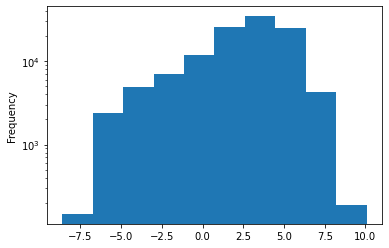

In [ ]:
gdsc["LN_IC50"].plot(kind='hist', logy=True)

<AxesSubplot:ylabel='Frequency'>

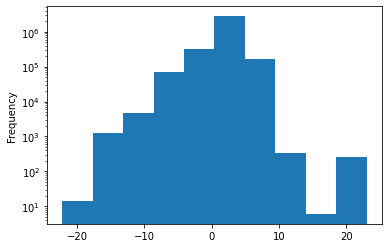

In [ ]:
nci_public["LN_IC50"].plot(kind='hist', logy=True)

In [ ]:
sample_info= pd.read_csv('/workspace/raw/depmap22q2/sample_info.csv')

In [ ]:
# print(NCI60_ccl_raw.head())
# print(NCI60_ccl_raw.columns)
# print(len(NCI60_ccl_raw))

# print(NCI60_PubChemSID)
# print(NCI60_PubChemSID.columns)
# print(len(NCI60_PubChemSID))


In [ ]:

# print(NCI60_IC50_PUBCHEM)
# print(NCI60_IC50_PUBCHEM.columns)
# print(len(NCI60_IC50_PUBCHEM))

## Basic exploration after all the data had been produced

In [ ]:
gdsc_pub_cell = pd.read_pickle('workspace/data/processed/GDSC_fs/gdsc_feature_selection_data.pkl')

<AxesSubplot:ylabel='Frequency'>

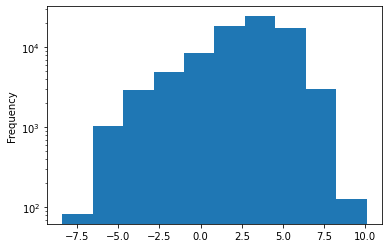

In [ ]:
gdsc_pub_cell['LN_IC50'].plot(kind='hist', logy= True)

<AxesSubplot:ylabel='Frequency'>

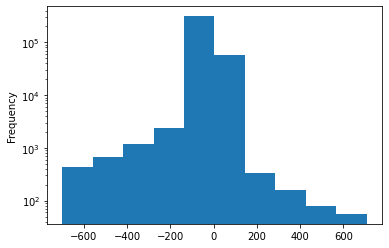

In [ ]:
ctrp_new['LN_EC50'][ctrp_new['LN_EC50']>-1000].plot(kind='hist', logy= True)

There is a big difference in reporting EC50 and IC50 results. EC50 is relative therefore if drugs are ineffective, the curve can behave like a horizontal line, in which case the median of inhibition measurements is taken. The slope of the curve can be positive or negative. For example, if a drug is determined to have the opposite effect of inhibition on a tumor cell, it can result in a negative slope.

In [ ]:
nci_public = pd.read_pickle('/workspace/data/raw/NCI60June2022/NCI60_IC50_PUBCHEM_PUBLIC.pkl')

<AxesSubplot:ylabel='Frequency'>

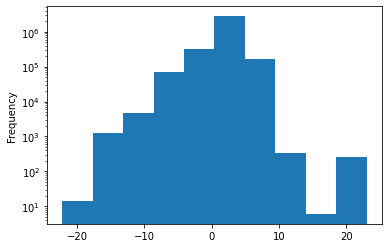

In [ ]:
nci_public["LN_IC50"].plot(kind='hist', logy=True)

By loading the LN_IC50 data from the NCI60 DB, we notice that the target variables are similarly distributed, but there are significant differences in the experimental procedure. In GDSC2 DB, the maximum target value is 10, and the minimum is around -8, while in NCI60 DB, the maximum is above 20, and the minimum is below 20. The distributions are visibly shifted. It is also essential to note that in NCI60, there are $10^6$ or more data points, while in CTRPv2 DB, we have a total of $10^5$ examples. See the graphs above. If these hypothetically different DB were learned in the model, it would result in poor predictions, and the data imbalance would create irreversible model bias, resulting in weak data generalization.

<AxesSubplot:ylabel='Frequency'>

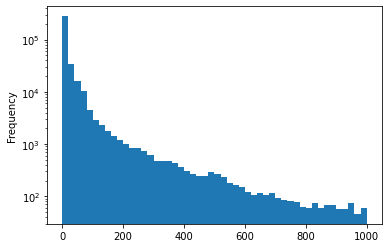

In [ ]:
# Prkaz koncentracije spojeva manje od 1uM u CTRPv2 BP na histogramu 
ctrp_new['apparent_ec50_umol'][ctrp_new['apparent_ec50_umol']<1000].plot(kind='hist', logy= True, bins=50)

<AxesSubplot:ylabel='Frequency'>

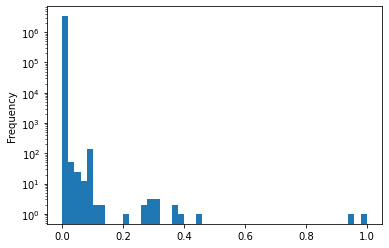

In [ ]:
nci_public["IC50"][nci_public["IC50"]<=1].plot(kind='hist', logy=True, bins=50)